# SIMIND MonteCarlo Simulation with SIRF Integration

In [19]:
# Import the necessary modules
from sirf.STIR import (ImageData, AcquisitionData, MessageRedirector)
from src.simulator import SimindSimulator
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import os
import numpy as np

In [20]:
# Redirect STIR messages
msg = MessageRedirector()

# We'll hardcode these for the purpose of this notebook. There are some scripts available in the `scripts` folder to run the demonstration for different isotopes.
total_activity = 258.423  # in MBq
time_per_projection = 43  # in seconds
photon_multiplier = 1 # controls the number of photons simulated
photopeak_energy = 208  # keV
window_lower = [176.54, 187.56, 229.31]  # keV
window_upper = [187.46, 229.24, 243.49]  # keV
source_type = 'lu177' 
collimator = 'G8-MEGP'
kev_per_channel = 10.0
max_energy = 498.3
mu_map_path = 'data/Lu177/registered_CTAC.hv'
image_path = 'data/Lu177/osem_image.hv' # we will use the OSEM image as an estimate of the activity distribution
measured_data_path = 'data/Lu177/SPECTCT_NEMA_128_EM001_DS_en_1_Lu177_EM.hdr'
measured_additive = 'data/Lu177/tew_scatter.hs'
output_dir = 'simind_output'
output_prefix = 'output'
input_smc_file_path = 'input/input.smc'
scoring_routine = 1
collimator_routine = 0 # Faster collimator routune using analytical weighting
photon_direction = 2 # Only model photons that are within a solid angle defined by the collimator
crystal_thickness = 7.25  # mm
crystal_half_length_radius = 393.6 / 2  # mm
crystal_half_width = 511.7 / 2  # mm
flag_11 = True

# Calculating the number of energy spectra channels
num_energy_spectra_channels = max_energy // kev_per_channel

Let's load the sirf data objects that we'll need for the simulation. These are:
- A source image
- Some measured data
- An attenuation coefficent map (optional)

In [21]:
# Load image, mu_map, measured data, and measured additive data
image = ImageData(image_path)
mu_map = ImageData(mu_map_path)
measured_data = AcquisitionData(measured_data_path)
measured_additive = AcquisitionData(measured_additive)

# Adjusting mu_map for STIR
mu_map_stir = mu_map.clone()
mu_map_stir.fill(np.flip(mu_map.as_array(), axis=2))

Now we'll set up the simulator as well as the SIMIND indices, flags and runtime switches that we require

In [22]:
# Set up the SIMIND simulator. This takes some values from the input files such as number of projections, voxel sizes, etc.
simulator = SimindSimulator(template_smc_file_path=input_smc_file_path,
                            output_dir=output_dir, output_prefix=output_prefix,
                            source=image, mu_map=mu_map, template_sinogram=measured_data)

# Add a comment to the simulation
simulator.add_comment("Demonstration of SIMIND simulation")

# Set the energy windows that we want to simulate. The third argument is the number of scatter orders that we want to simulate.
simulator.set_windows(window_lower, window_upper, [0]*len(window_lower))

# Set SIMIND indices that we want to change from the input SMC file
simulator.add_index("photon_energy", photopeak_energy)
simulator.add_index("scoring_routine", scoring_routine)
simulator.add_index("collimator_routine", collimator_routine)
simulator.add_index("photon_direction", photon_direction)
simulator.add_index("source_activity", total_activity * time_per_projection)
simulator.add_index("crystal_thickness", crystal_thickness / 10)  # cm
simulator.add_index("crystal_half_length_radius", crystal_half_length_radius / 10)  # cm
simulator.add_index("crystal_half_width", crystal_half_width / 10)  # cm
simulator.add_index("step_size_photon_path_simulation", min(*image.voxel_sizes()) / 10)  # cm
simulator.add_index("energy_resolution", 9.5)  # percent
simulator.add_index("intrinsic_resolution", 0.31)  # cm

# Set flags that we want to change form the input SMC file
simulator.config.set_flag(11, flag_11) # set flag 11 to use a collimator

# Set runtime switches - these will not update the SMC file but will be used during the simulation
simulator.add_runtime_switch("CC", collimator) # this sets the collimator type to a list of predefined collimators in smc_dir/collim.col
simulator.add_runtime_switch("NN", photon_multiplier) # This controls the number of simulated photons
simulator.add_runtime_switch("FI", source_type) # This sets the isotope type

We can check the current SIMIND configuration by either using `simulator.config.get_value()` or by printing the entire configuration

In [23]:
simulator.config.print_config()

Comment: Demonstration of SIMIND simulation
Basic Change data:
index 1: photon_energy: 208
index 2: source_half_length: 28.286337280273436
index 3: source_half_width: 28.286337280273436
index 4: source_half_height: 28.286337280273436
index 5: phantom_half_length: 28.286337280273436
index 6: phantom_half_width: 28.286337280273436
index 7: phantom_half_height: 28.286337280273436
index 8: crystal_half_length_radius: 19.68
index 9: crystal_thickness: 0.725
index 10: crystal_half_width: 25.585
index 11: backscattering_material_thickness: 10.0
index 12: height_to_detector_surface: 19.1125
index 13: cover_thickness: 0.12
index 14: phantom_type: -1
index 15: source_type: -1
index 16: shift_source_x: 0.0
index 17: shift_source_y: 0.0
index 18: shift_source_z: 0.0
index 19: photon_direction: 2
index 20: upper_window_threshold: -100.0
index 21: lower_window_threshold: -100.0
index 22: energy_resolution: 9.5
index 23: intrinsic_resolution: 0.31
index 24: emitted_photons_per_decay: 0.879
index 25: 

And now we can run the simulation. This will save a new configuration (.smc) file in the output folder.

In [24]:
simulator.run_simulation()

Running simind with command: simind output output /PX:0.44197402000427244/TH:0.44197402000427244/NN:1/CC:G8-MEGP/FI:lu177
 



              SIMIND Monte Carlo Simulation Program    V8.0  
------------------------------------------------------------------------------
 Phantom S : h2o       Crystal...: nai       InputFile.: output            
 Phantom B : bone      BackScatt.: pmt       OutputFile: output            
 Collimator: pb_sb2    SourceRout: smap      SourceImg.: tmp_source        
 Cover.....: al        ScoreRout.: scattwin  DensityImg: tmp_density       
------------------------------------------------------------------------------
 PhotonEnergy.......: 208          lu177     PhotonsPerProj....: 106187         
 EnergyResolution...: 9.5          Spectra   Activity..........: 11112          
 MaxScatterOrder....: 3            g8-megp   DetectorLenght....: 19.68          
 DetectorWidth......: 25.585       SPECT     DetectorHeight....: 0.725          
 UpperEneWindowTresh: 312

In [25]:
# Retrieve simulation outputs
simind_total = simulator.get_output_total(2)
simind_scatter = simulator.get_output_scatter(2)
simind_true = simind_total - simind_scatter

Output in /home/sam/working/STIR_users_MIC2023/simind_output/output_tot_w3.hs

Converted output_tot_w3.h00

Output in /home/sam/working/STIR_users_MIC2023/simind_output/output_air_w1.hs

Converted output_air_w1.h00

Output in /home/sam/working/STIR_users_MIC2023/simind_output/output_tot_w1.hs

Converted output_tot_w1.h00

Output in /home/sam/working/STIR_users_MIC2023/simind_output/output_sca_w1.hs
Converted output_sca_w1.h00


Output in /home/sam/working/STIR_users_MIC2023/simind_output/output_sca_w4.hs
Converted output_sca_w4.h00


Output in /home/sam/working/STIR_users_MIC2023/simind_output/output_tot_w2.hs
Converted output_tot_w2.h00


Output in /home/sam/working/STIR_users_MIC2023/simind_output/output_sca_w3.hs
Converted output_sca_w3.h00


Output in /home/sam/working/STIR_users_MIC2023/simind_output/output_sca_w2.hs
Converted output_sca_w2.h00


Output in /home/sam/working/STIR_users_MIC2023/simind_output/output_air_w2.hs
Converted output_air_w2.h00


Output in /home/sam/working/

(0.0, 128.0)

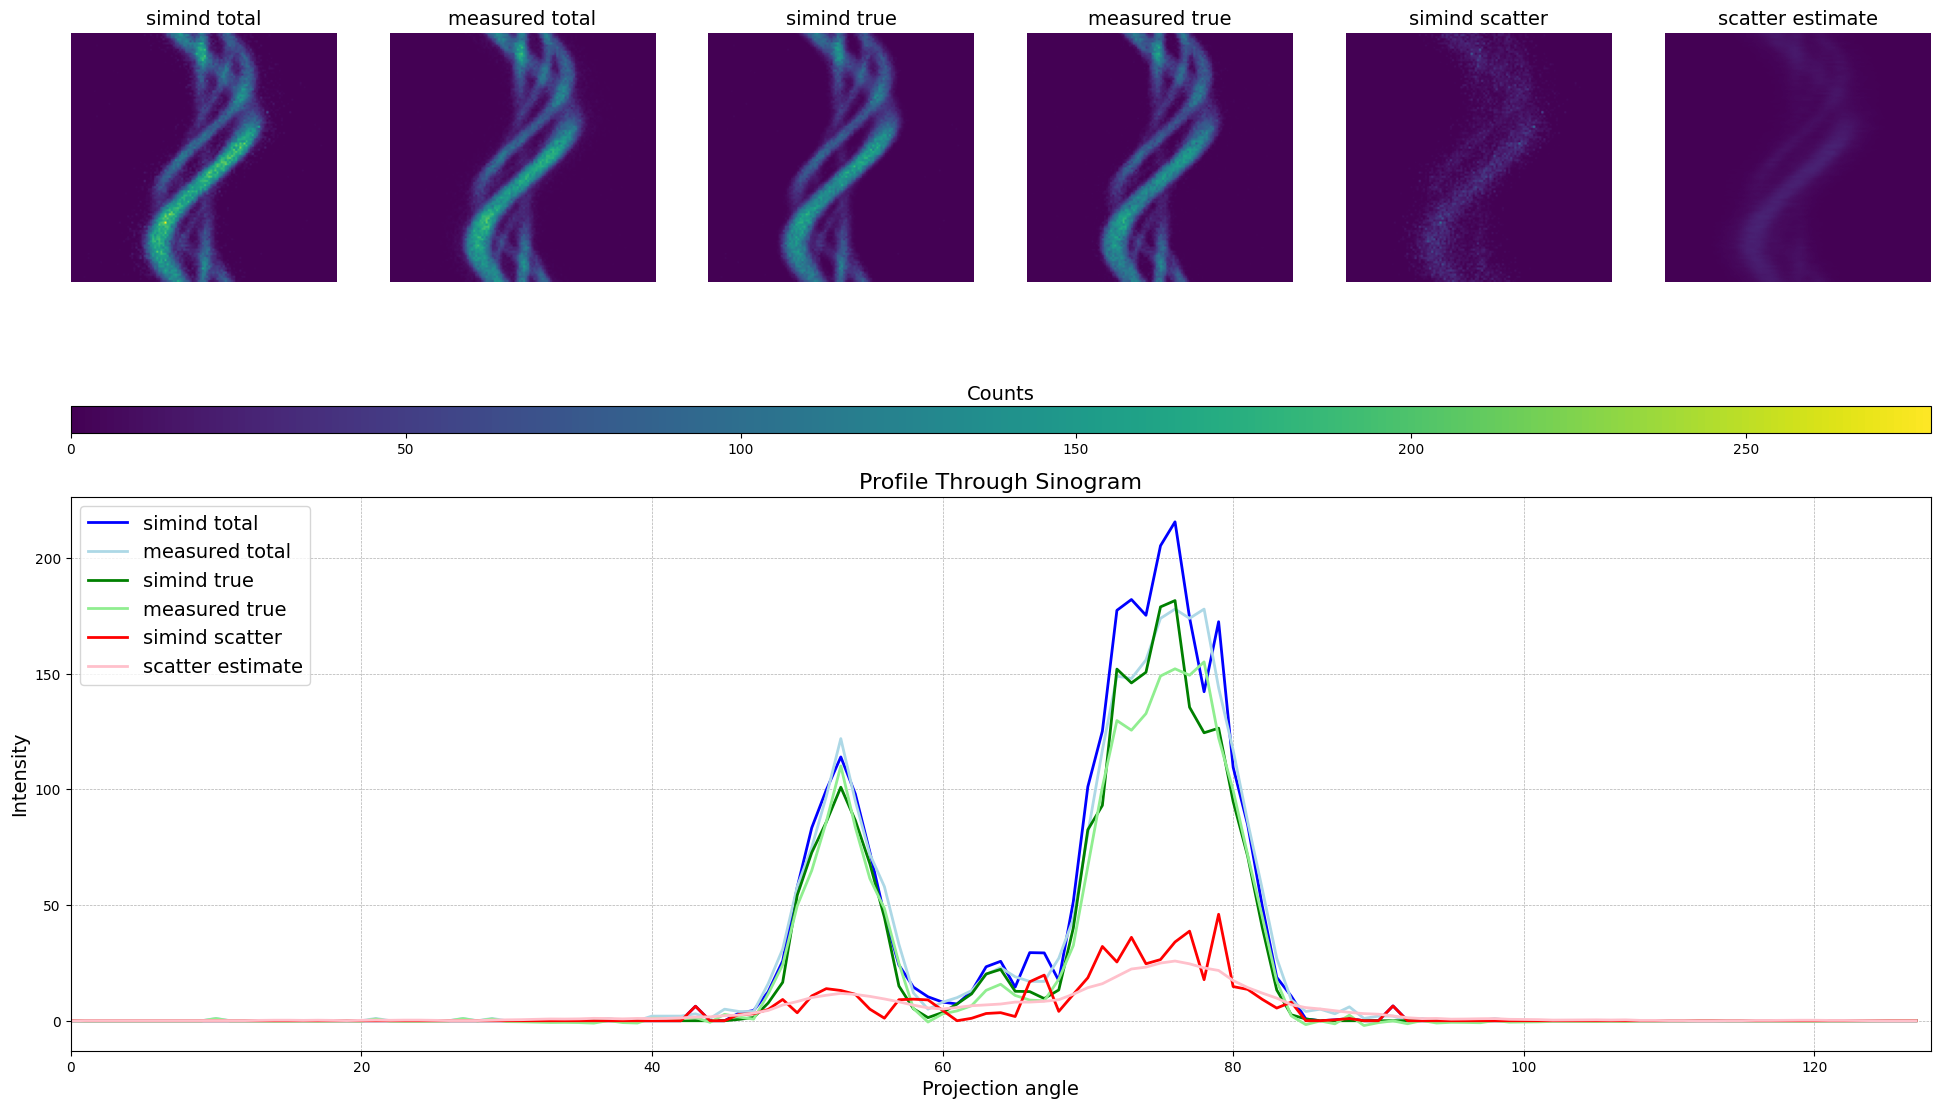

In [26]:
# Define the data to be plotted
data_list = [
    ((simind_total), "simind total"),
    ((measured_data), "measured total"),
    ((simind_true), "simind true"),
    ((measured_data-measured_additive), "measured true"),
    ((simind_scatter), "simind scatter"),
    ((measured_additive), "scatter estimate"),
]

data_list = [(data.as_array(), title) for data, title in data_list]

# Plot the axial slice
axial_slice = 66
vmax = max([data[0][axial_slice].max() for data, _ in data_list])

# Define consistent font size and colormap
font_size = 14
colormap = 'viridis'

# Create a figure and a GridSpec with 3 rows
fig = plt.figure(figsize=(len(data_list) * 4, 7 * 2))
gs = GridSpec(3, len(data_list), height_ratios=[2, 0.15, 3])  # Adjusted GridSpec for clarity

# Create image subplots
ax_images = [fig.add_subplot(gs[0, i]) for i in range(len(data_list))]

for i, (data, title) in enumerate(data_list):
    im = ax_images[i].imshow(data[0, axial_slice], vmin=0, vmax=vmax, cmap=colormap)
    ax_images[i].set_title(f"{title}", fontsize=font_size)
    ax_images[i].axis('off')

# Create a colorbar
cbar_ax = fig.add_subplot(gs[1, :])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=0.02)
cbar_ax.set_xlabel('Counts', fontsize=font_size)
cbar_ax.xaxis.set_label_position('top')

# Plot the line plot
ax_line = fig.add_subplot(gs[2, :])
# one colour for total, true and scatter. Different shade for SIMIND and measured
colours = ['blue', 'lightblue', 'green', 'lightgreen', 'red', 'pink']
for i, (data, title) in enumerate(data_list):
    ax_line.plot(data[0, axial_slice][60], linewidth=2, color=colours[i], linestyle='-', label=title)

# Enhance the line plot appearance
ax_line.set_xlabel('Projection angle', fontsize=font_size)
ax_line.set_ylabel('Intensity', fontsize=font_size)
ax_line.set_title(f'Profile Through Sinogram', fontsize=font_size + 2)
ax_line.grid(True, which='both', linestyle='--', linewidth=0.5)
ax_line.legend(loc='upper left', fontsize=font_size)
ax_line.set_xlim(0, 128)

(0.0, 128.0)

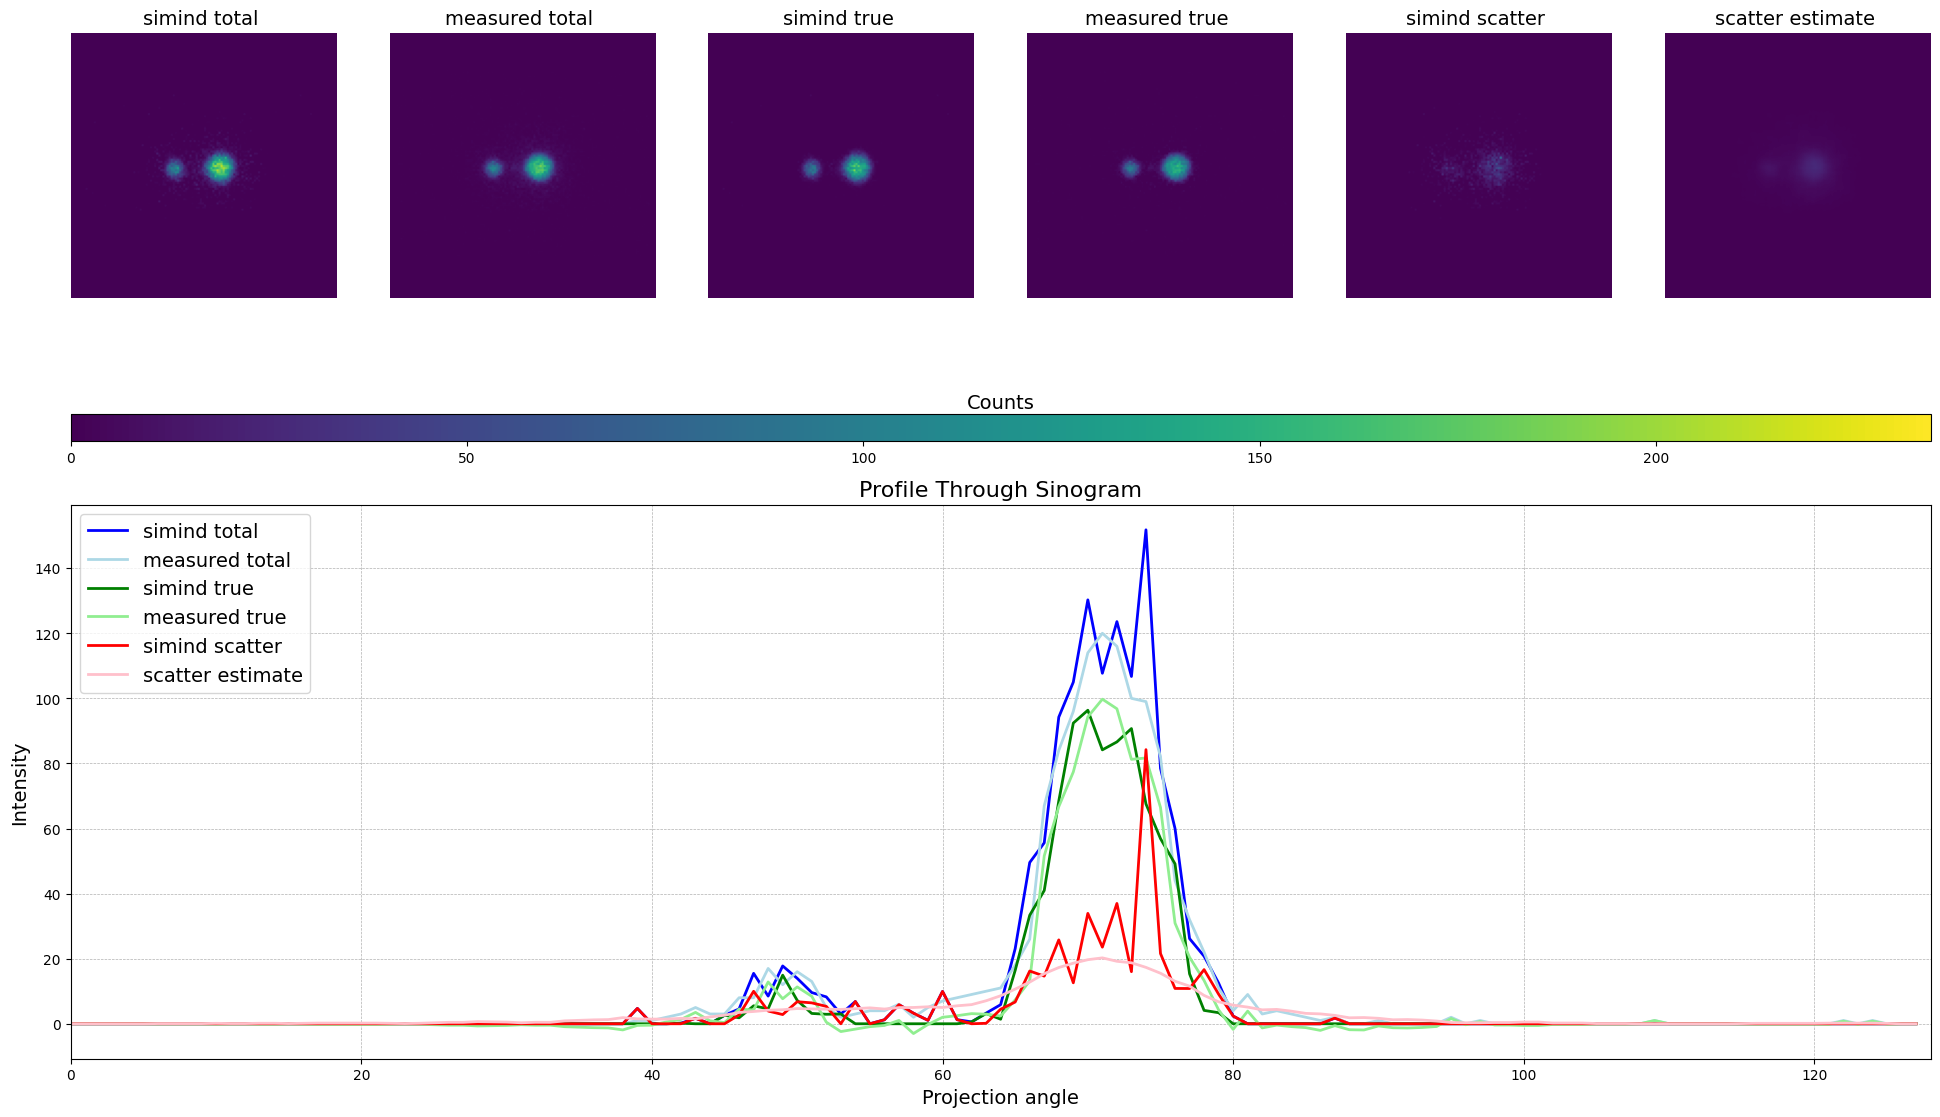

In [27]:
coronal_slice = 64
# Create coronal subplots
ax_coronal = [fig.add_subplot(gs[2, i]) for i in range(len(data_list))]
vmax = max([data[0][coronal_slice].max() for data, _ in data_list])

# Create a figure and a GridSpec with 3 rows
fig = plt.figure(figsize=(len(data_list) * 4, 7 * 2))
gs = GridSpec(3, len(data_list), height_ratios=[2, 0.15, 3])  # Adjusted GridSpec for clarity

# Create image subplots
ax_images = [fig.add_subplot(gs[0, i]) for i in range(len(data_list))]

for i, (data, title) in enumerate(data_list):
    im = ax_images[i].imshow(data[0, :, coronal_slice], vmin=0, vmax=vmax, cmap=colormap)
    ax_images[i].set_title(f"{title} ", fontsize=font_size)
    ax_images[i].axis('off')

# Create a colorbar
cbar_ax = fig.add_subplot(gs[1, :])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=0.02)
cbar_ax.set_xlabel('Counts', fontsize=font_size)
cbar_ax.xaxis.set_label_position('top')

# Plot the line plot
ax_line = fig.add_subplot(gs[2, :])
for i, (data, title) in enumerate(data_list):
    ax_line.plot(data[0, :, coronal_slice][60], linewidth=2, color=colours[i], linestyle='-', label=title)

# Enhance the line plot appearance
ax_line.set_xlabel('Projection angle', fontsize=font_size)
ax_line.set_ylabel('Intensity', fontsize=font_size)
ax_line.set_title(f'Profile Through Sinogram', fontsize=font_size + 2)
ax_line.grid(True, which='both', linestyle='--', linewidth=0.5)
ax_line.legend(loc='upper left', fontsize=font_size)
ax_line.set_xlim(0, 128)